## Analysis of the linker library
In this notebook, we do the analysis of the aligned reads (output of `preprocess_and_align_Illumina_reads.py`). 
You can also run `Illumina_analyze_linkers.py` to run this first part in an automated way. 

Below, we then do some more specific analysis and plots, by comparing the different Barcodes and runs. 

In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Illumina_functions import *
from linker_analysis_functions import *

In [15]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

### Processing and standard analysis 
This first part is also automized in the `characterize_indels_from_blast.py` file. 

In [46]:
import json

Bc = "BC1"
read_dir = "R1"
variant = "R36"
homedir = "/home/student/anna/DMS_analysis/data/Illumina/R36/"
base_dir = os.getcwd()

# Open the JSON file and load it as a dictionary
with open(f"{homedir}/blast/alignments/{variant}_{Bc}_S1_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>

with open(f"{homedir}/config.json") as f:
    config = json.load(f)

###########

FigFolder = f"{base_dir}/final_output/{variant}/notebook/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

amplicon_seq = config["amplicon"]

blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
wt_left_linker = "INESSGL"
wt_right_linker = "IDEAAKGSLHPP"

LOV_startseq = "gccacaa".upper() ## LOV2 start # set region of interest, that has to be included in the reads to be considered for the analysis, e.g. LOV2 start site
LOV_endseq = "tgctgaaaac".upper() 

### 
#LOV_startseq = "gggagcctgcatcc".upper() ### GSLHP (left side after linker)

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()



LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)


<class 'dict'>


In [47]:
### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx  ########


blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


31553 alignments before filtering for LOV2 insertion site
22475 alignments after filtering for LOV2 insertion site


In [48]:
cut_site_seq = LOV_startseq if read_dir=="R1" else LOV_endseq

print(LOV_startseq)
linker_alignments, LOV2_alignments, covarage = divide_alignments(blast_alignments,cut_site_seq, query_seq=LOV2_gene ,read_dir=read_dir)
    

GCCACAA
2 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [49]:
linker_alignments

{'M02654:611:000000000-LVGC2:1:2118:17904:21533 R36 BC1 DNA sequence': {'qseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'hseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'midline': '||||||||||||||||||||||||'},
 'M02654:611:000000000-LVGC2:1:2118:14142:21079 R36 BC1 DNA sequence': {'qseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'hseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'midline': '||||||||||||||||||||||||'},
 'M02654:611:000000000-LVGC2:1:2118:12423:20942 R36 BC1 DNA sequence': {'qseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'hseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'midline': '||||||||||||||||||||||||'},
 'M02654:611:000000000-LVGC2:1:2118:8284:20815 R36 BC1 DNA sequence': {'qseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'hseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'midline': '||||||||||||||||||||||||'},
 'M02654:611:000000000-LVGC2:1:2118:4937:20649 R36 BC1 DNA sequence': {'qseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'hseq': 'GCGATTAACGAAAGCAGCGGTTTA',
  'midline': '||||||||||||||||||||||||'},
 'M02654:611:000000000-LVGC2:1:2118:25009:19298 R36 BC1 DNA se

In [50]:
linkers, linker_list = get_linker_variants(linker_alignments,wt_linker = wt_left_linker if read_dir=="R1" else wt_right_linker, read_dir=read_dir)

272 reads excluded due to frameshifts


In [51]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.05}

linkers_perc_filt, linker_renaming = rename_left_linkers(linkers_perc_filt.keys(), linkers_perc_filt) if read_dir=="R1" else rename_right_linkers(linkers_perc_filt.keys(), linkers_perc_filt)


INESSGL -> SG
INESVL -> V
INESPL -> P
INESLL -> L
INESSL -> S
INESKL -> K
INESWL -> W
INESAL -> A
INESRL -> R
INESQL -> Q
INESTL -> T
INESNL -> N
INESCL -> C
INESGL -> G
INESFL -> F
INESHL -> H
INESDL -> D
INESML -> M
INESGTGL -> GTG
INESGSGL -> GSG
INESGWGL -> GWG
INESGVGL -> GVG
INESGAGL -> GAG
INESGMGL -> GMG
INESIL -> I
INESPPL -> PP
INESEL -> E
INESGQGL -> GQG
INESGGL -> GG
INESGCGL -> GCG
INESGKGL -> GKG
INESGGGL -> GGG
INESGEGL -> GEG
INESYL -> Y
INESGRGL -> GRG
INESGHGL -> GHG
INESGDGL -> GDG
INESGPGL -> GPG
INESGFGL -> GFG
INESGIGL -> GIG
INESGNGL -> GNG
INESGYGL -> GYG
INESGLGL -> GLG
INESGPPPGL -> GPPPG
INESGSGGL -> GSGG
INESGSGSGL -> GSGSG
INESGGSGL -> GGSG
INESGPPGL -> GPPG
INEL -> (-1del)
INESSDL -> SD


In [52]:
sum(linkers_perc_filt.values())

23.710643664699784

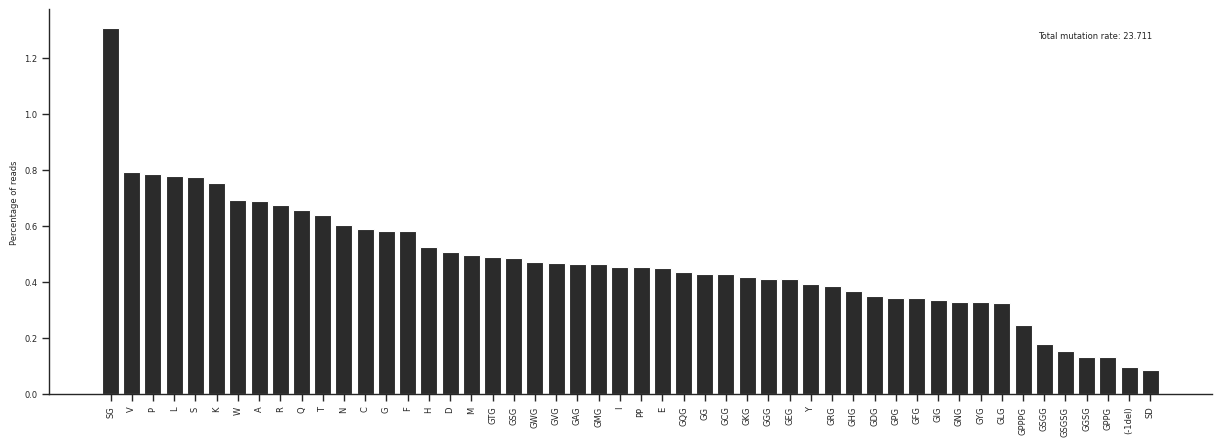

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

In [ ]:
linker_variants_perc = pd.DataFrame.from_dict(linkers_perc_filt, orient = "index")

linker_variants_perc.to_csv(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.csv")

with open(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_renaming.json", "w") as file:
    json.dump(linker_renaming, file)

## Specific analysis and comparison 
Please run the `characterize_indels_from_blast.py` (automatized) or the analysis above first, so that the analyzed data is present. 

First, we analyze the POGO evolution of the Illumina data.

In [4]:
left_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T

left_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC2_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC2_S1_R2_AA_linker_distribution.csv", index_col=0).T

left_linker_BC3 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC3_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC3 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC3_S1_R2_AA_linker_distribution.csv", index_col=0).T


In [5]:
## get all linkers that are present in the data and their frequencies for each BC
all_right_linkers_vars = list(set(list(right_linker_BC1.columns) + list(right_linker_BC2.columns) + list(right_linker_BC3.columns)))
all_right_linker_perc = pd.DataFrame(columns = all_right_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_right_linkers_vars: 
    if linker in right_linker_BC1.columns:
        all_right_linker_perc.loc["BC1", linker] = right_linker_BC1.loc["0", linker]
    if linker in right_linker_BC2.columns:
        all_right_linker_perc.loc["BC2", linker] = right_linker_BC2.loc["0", linker] 
    if linker in right_linker_BC1.columns:
        all_right_linker_perc.loc["BC3", linker] = right_linker_BC1.loc["0", linker]

In [6]:
all_left_linkers_vars = list(set(list(left_linker_BC1.columns) + list(left_linker_BC2.columns) + list(left_linker_BC3.columns)))
all_left_linker_perc = pd.DataFrame(columns = all_left_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_left_linkers_vars:
    if linker in left_linker_BC1.columns:
        all_left_linker_perc.loc["BC1", linker] = left_linker_BC1.loc["0",linker]
    if linker in left_linker_BC2.columns:
        all_left_linker_perc.loc["BC2", linker] = left_linker_BC2.loc["0",linker]
    if linker in left_linker_BC3.columns:
        all_left_linker_perc.loc["BC3", linker] = left_linker_BC3.loc["0",linker]

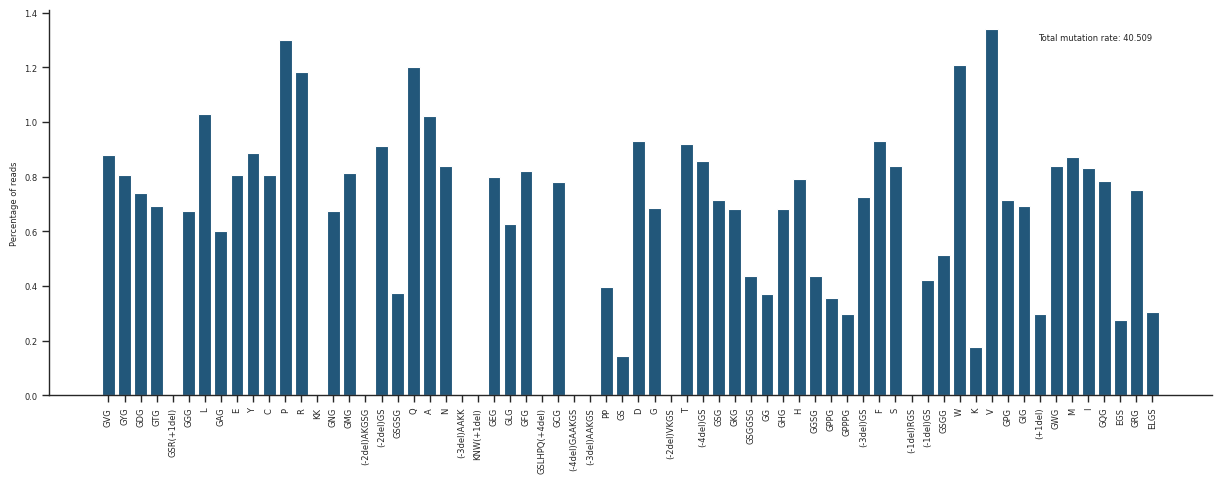

In [7]:
Barcode = "BC1"
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(all_right_linker_perc.columns, all_right_linker_perc.loc[Barcode,:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(all_right_linker_perc.loc[Barcode,:].values),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

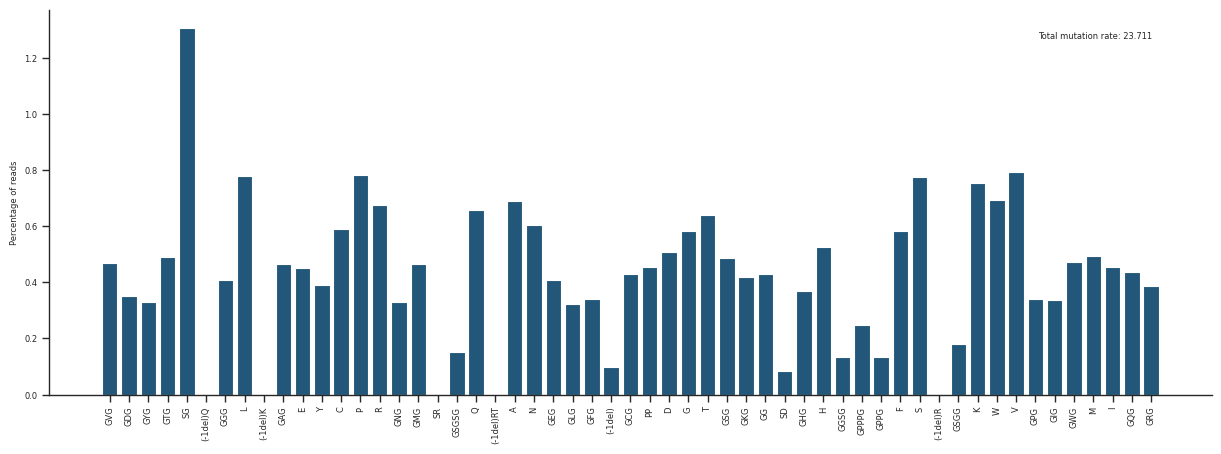

In [8]:
Barcode = "BC1"
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(all_left_linker_perc.columns, all_left_linker_perc.loc[Barcode,:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(all_left_linker_perc.loc[Barcode,:].values),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

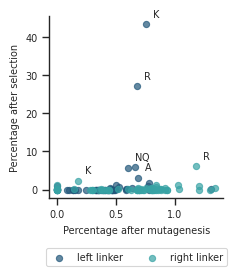

In [39]:
fig, ax = plt.subplots(figsize = (wi3, hi/3))
compared_to = "BC2"
plt.scatter(all_left_linker_perc.loc["BC1",:], all_left_linker_perc.loc[compared_to,:], color = "#22577A", alpha=0.7, label = "left linker", s = 20)
plt.scatter(all_right_linker_perc.loc["BC1",:], all_right_linker_perc.loc[compared_to,:], color = "#38A3A5",alpha=0.7, label = "right linker", s = 20)

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),ncol =2)


##
# 80ED99
# 38A3A5
# 57CC99
plt.xlabel("Percentage after mutagenesis")
plt.ylabel("Percentage after selection")
for i, (x, y) in enumerate(zip(all_left_linker_perc.loc["BC1", :], all_left_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_left_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

for i, (x, y) in enumerate(zip(all_right_linker_perc.loc["BC1", :], all_right_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_right_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/R36/combined/plots/AA/R36_linker_evolution_scatter_BC1vs{compared_to}.pdf", bbox_inches='tight', dpi = 600)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/R36/combined/plots/AA/R36_linker_evolution_scatter_BC1vs{compared_to}.png", bbox_inches='tight')

plt.show()


Secondly, we analyze the combination of the DMS and the linker library 

In [40]:
#### R35

left_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/R1/enrichments/AA/R35_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/R2/enrichments/AA/R35_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T

left_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/R1/enrichments/AA/R35_BC2_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/R2/enrichments/AA/R35_BC2_S1_R2_AA_linker_distribution.csv", index_col=0).T

BC1_enrichment = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/combined/enrichments/AA/R35_BC1_S1_combined_AA_enrichment_relative.csv", index_col=0)
BC2_enrichment = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R35/combined/enrichments/AA/R35_BC2_S1_combined_AA_enrichment_relative.csv", index_col=0)

ref_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAEN"

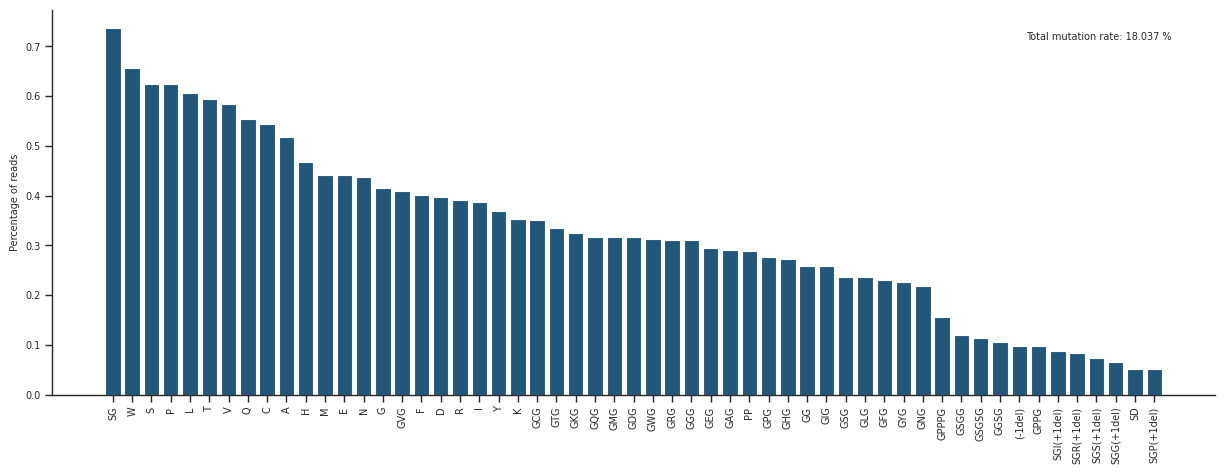

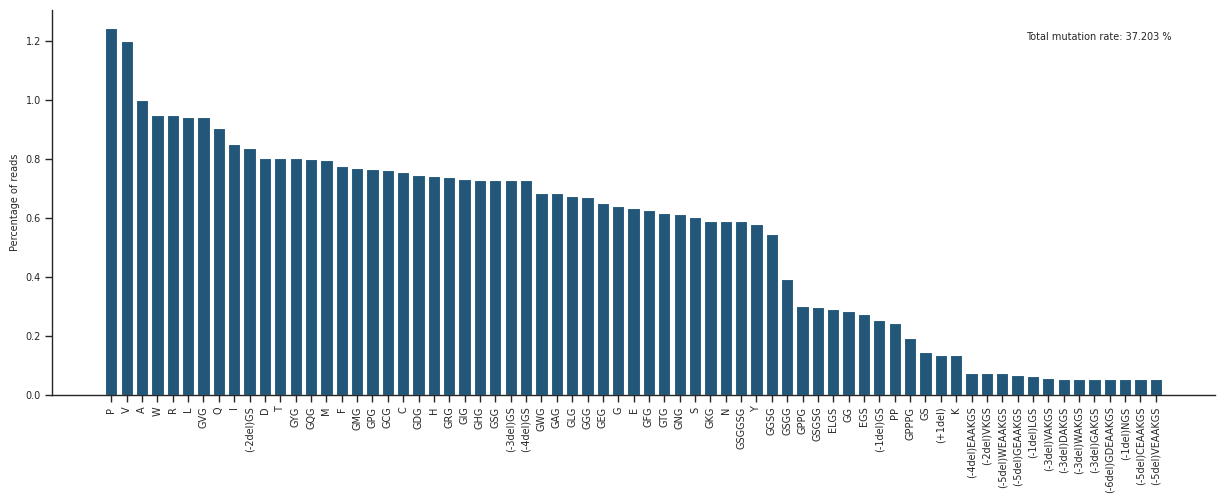

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(left_linker_BC2.columns, left_linker_BC2.loc["0",:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(left_linker_BC2.loc['0',:].values),3)} %", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(right_linker_BC2.columns, right_linker_BC2.loc["0",:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(right_linker_BC2.loc['0',:].values),3)} %", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

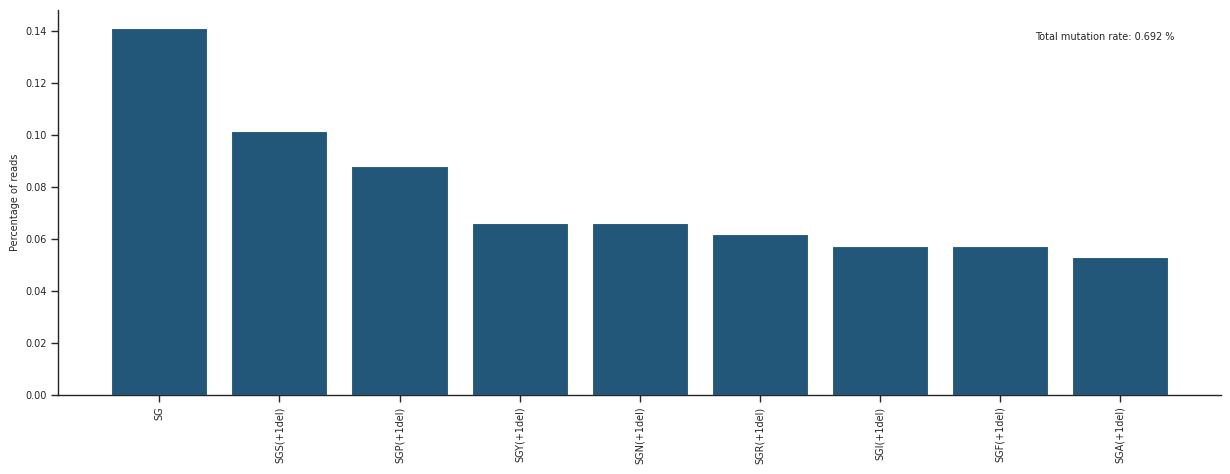

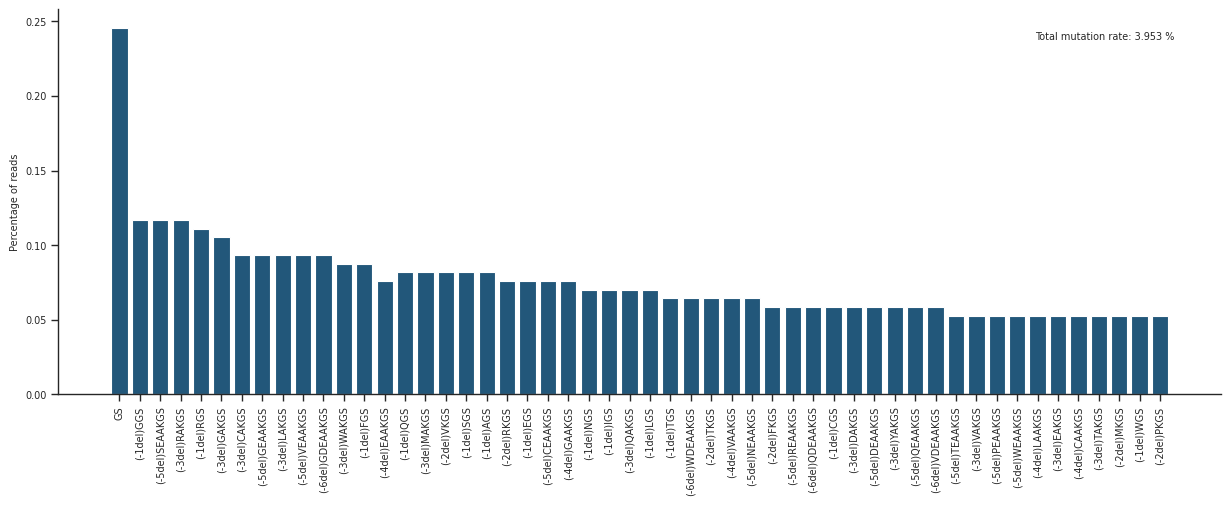

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(left_linker_BC1.columns, left_linker_BC1.loc["0",:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(left_linker_BC1.loc['0',:].values),3)} %", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(right_linker_BC1.columns, right_linker_BC1.loc["0",:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(right_linker_BC1.loc['0',:].values),3)} %", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

In [43]:
BC1_enrichment = BC1_enrichment*100
BC2_enrichment = BC2_enrichment*100

/tmp/ipykernel_1101137/858060452.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp0 = ax[0,0].boxplot([BC1_enrichment.sum()],
/tmp/ipykernel_1101137/858060452.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax[0,1].boxplot([left_linker_BC1.iloc[0, :] if not left_linker_BC1.empty else 0.0, right_linker_BC1.iloc[0, :]],
/tmp/ipykernel_1101137/858060452.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax[1,0].boxplot([BC2_enrichment.sum()],
/tmp/ipykernel_1101137/858060452.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.

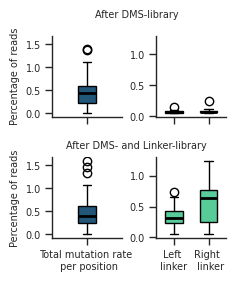

In [71]:
import matplotlib.pyplot as plt

# Define colors
color_ax0 = "#22577A"  # Replace with actual color (e.g., "#1f77b4")
color_ax1 = "#57CC99"  # Replace with actual color (e.g., "#ff7f0e")

fig, ax = plt.subplots(2, 2, figsize=(wi3, hi/3))
fig.subplots_adjust(hspace = 0.5,wspace = 0.5)


# Boxplot for first axis (Mutation rate per position)
bp0 = ax[0,0].boxplot([BC1_enrichment.sum()], 
                     labels=[""], 
                     patch_artist=True, showfliers=True, widths=0.25)
bp1 = ax[0,1].boxplot([left_linker_BC1.iloc[0, :] if not left_linker_BC1.empty else 0.0, right_linker_BC1.iloc[0, :]], 
                     labels=["", 
                             ""], 
                     patch_artist=True, showfliers=True, widths=0.5)

# Boxplot for second axis (Linker variants)
bp2 = ax[1,0].boxplot([BC2_enrichment.sum()], 
                     labels=["Total mutation rate \n per position"], 
                     patch_artist=True, showfliers=True, widths=0.25)
bp3 = ax[1,1].boxplot([left_linker_BC2.iloc[0, :], right_linker_BC2.iloc[0, :]], 
                     labels=["Left \n linker ", 
                             "Right \n linker"], 
                     patch_artist=True, showfliers=True, widths=0.5)

ylim1_max = max(ax[0,0].get_ylim()[1], ax[1,0].get_ylim()[1])
ylim2_max = max(ax[0,1].get_ylim()[1], ax[1,1].get_ylim()[1])

ylim1_min = min(ax[0,0].get_ylim()[0], ax[1,0].get_ylim()[0])
ylim2_min = min(ax[0,1].get_ylim()[0], ax[1,1].get_ylim()[0])

ax[0,0].set_ylim(ylim1_min, ylim1_max)
ax[1,0].set_ylim(ylim1_min, ylim1_max)

ax[0,1].set_ylim(ylim2_min, ylim2_max)
ax[1,1].set_ylim(ylim2_min, ylim2_max)

# titles
fig.text(0.5, 0.95, "After DMS-library", ha='center')
fig.text(0.5, 0.45, "After DMS- and Linker-library", ha='center')

# Set colors for ax[0]
for box in bp0['boxes']:
    box.set(facecolor=color_ax0)

# Set colors for ax[1]
for box in bp1['boxes']:
    box.set(facecolor=color_ax1)
for box in bp2['boxes']:
    box.set(facecolor=color_ax0)

for box in bp3['boxes']:
    box.set(facecolor=color_ax1)

for median in bp0['medians']:
    median.set(color="black", linewidth=2)

for median in bp1['medians']:
    median.set(color="black", linewidth=2)

for median in bp2['medians']:
    median.set(color="black", linewidth=2)

for median in bp3['medians']:
    median.set(color="black", linewidth=2)

ax[1,0].set_ylabel("Percentage of reads")
ax[0,0].set_ylabel("Percentage of reads")

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/R35/combined/plots/AA/R35_RL8_RL1_combined_boxplot.pdf", bbox_inches='tight', dpi = 600)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/R35/combined/plots/AA/R35_RL8_RL1_combined_boxplot.png", bbox_inches='tight')

plt.show()


### Linker library mutagenesis round

In [72]:
left_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL1/R1/enrichments/AA/RL1_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL1/R2/enrichments/AA/RL1_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T

/tmp/ipykernel_1101137/296902962.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(left_linker_BC1.columns, rotation=90, fontsize = 5.5)
/tmp/ipykernel_1101137/296902962.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(right_linker_BC1.columns, rotation=90, fontsize = 5.5)


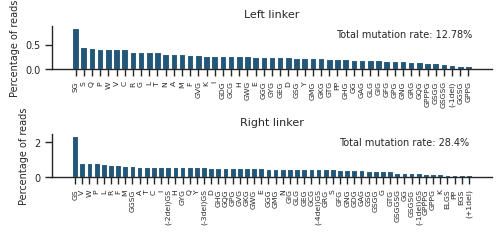

In [144]:
fig, ax = plt.subplots(2,1,figsize = (wi*0.8, hi/4))
fig.subplots_adjust(hspace =1.5)
ax[0].bar(left_linker_BC1.columns, left_linker_BC1.loc["0",:], color = "#22577A")
ax[0].set_xticklabels(left_linker_BC1.columns, rotation=90, fontsize = 5.5)
ax[0].text(0.8, 0.8, f"Total mutation rate: {round(sum(left_linker_BC1.loc['0',:]),2)}%", horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)
ax[0].set_title("Left linker")
ax[0].set_ylabel("Percentage of reads")

ax[1].bar(right_linker_BC1.columns, right_linker_BC1.loc["0",:], color = "#22577A")
ax[1].set_xticklabels(right_linker_BC1.columns, rotation=90, fontsize = 5.5)
ax[1].text(0.8, 0.8, f"Total mutation rate: {round(sum(right_linker_BC1.loc['0',:]),2)}%", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
ax[1].set_title("Right linker")
ax[1].set_ylabel("Percentage of reads")

plt.savefig("/home/student/anna/DMS_analysis/final_output/RL1/Linker_mutations_after_mutagenesis_barplot_both_linkers.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/RL1/Linker_mutations_after_mutagenesis_barplot_both_linkers.png", bbox_inches = "tight", dpi = 600)
